In [113]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import statsmodels

In [114]:
df = pd.read_csv("shampoo sales\shampoo_sales.csv")
df.rename(columns={'Sales': 'sales'}, inplace = True)
print(df.shape)
df.head()

(36, 2)


,Month,sales
0,1-01,266.0
1,1-02,145.9
2,1-03,183.1
3,1-04,119.3
4,1-05,180.3


In [115]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(df.sales)
print("ADF statistics: ", result[0])
print("p-value: ", result[1])

ADF statistics:  3.0601420836411797
p-value:  1.0


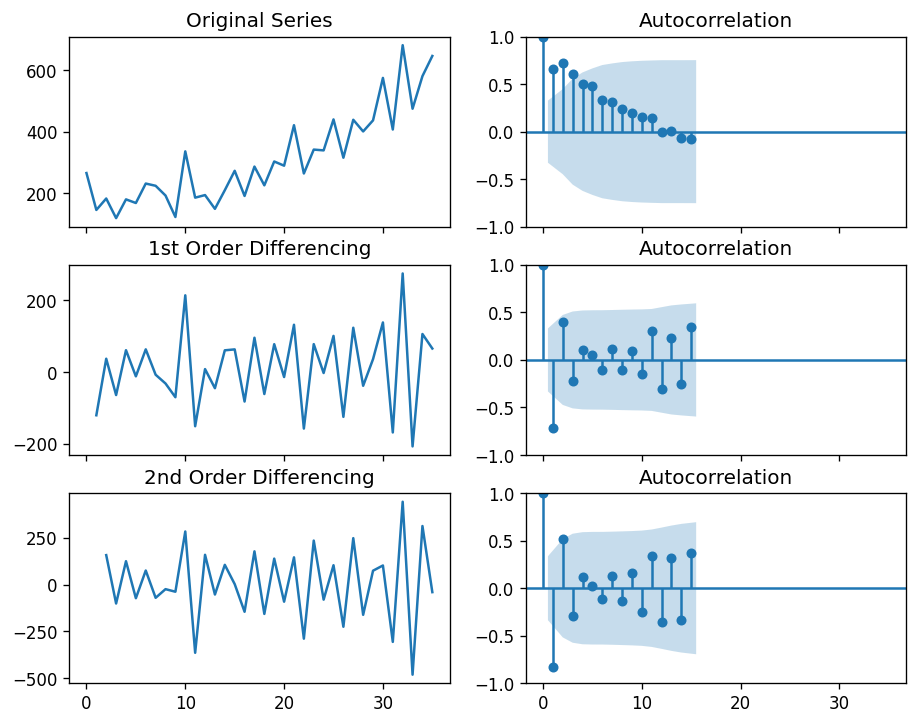

In [116]:
# Lets difference the series
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.rcParams.update({'figure.figsize':(9, 7), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3,2, sharex=True)
axes[0, 0].plot(df.sales); axes[0,0].set_title("Original Series")
plot_acf(df.sales, ax=axes[0,1], lags=15)

# 1st Differencing
axes[1, 0].plot(df.sales.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df.sales.diff().dropna(), ax=axes[1, 1], lags=15)

# 2nd Differencing
axes[2, 0].plot(df.sales.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df.sales.diff().diff().dropna(), ax=axes[2, 1], lags=15)

plt.show()

In [117]:
result_1_diff = adfuller(df.sales.diff().dropna())
print("ADF statistics: ", result_1_diff[0])
print("p-value: ", result_1_diff[1])

ADF statistics:  -7.249074055553856
p-value:  1.7998574141687034e-10


lets assume d = 1

<b>Find the order of the AR Term (p)</b>
using PACF

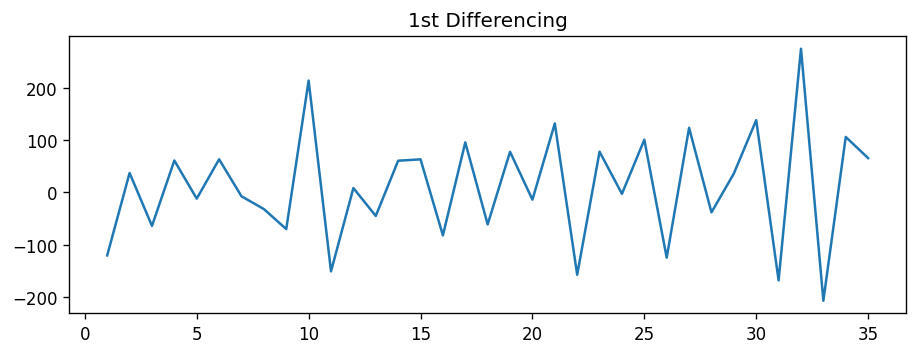

In [118]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 1, sharex=True)
axes.plot(df.sales.diff()); axes.set_title('1st Differencing')
plt.show()

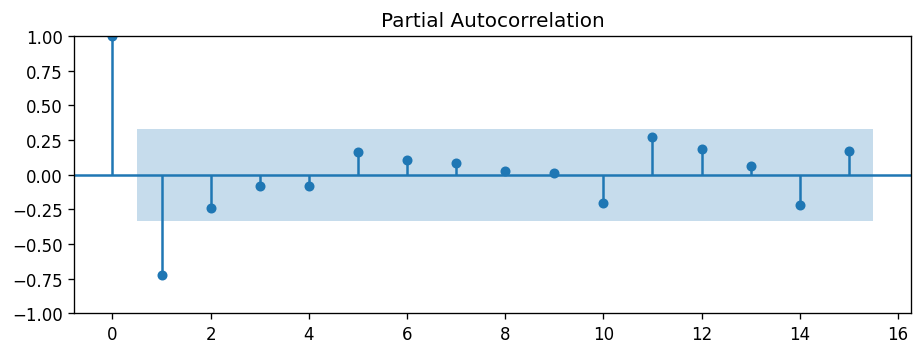

In [119]:
plot_pacf(df.sales.diff().dropna(), lags= 15)
plt.show()

from pacf plot lets assume p-value (p=1)

<b>Find the order of the MA term (q)</b> using ACF

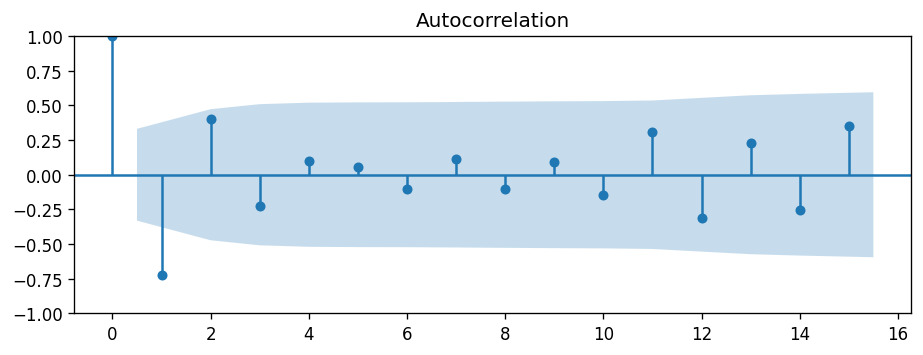

In [120]:
plot_acf(df.sales.diff().dropna(), lags=15)

plt.show()

let us assume Q value be (q=1)

<b>Build the ARIMA Model</b><br>
ARIMA(1, 1, 1) model

In [121]:
from statsmodels.tsa.arima.model import ARIMA

# 1,1,1 model
model = ARIMA(df.sales, order=(1,1,1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                   36
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -200.391
Date:                Wed, 02 Aug 2023   AIC                            406.782
Time:                        16:02:10   BIC                            411.448
Sample:                             0   HQIC                           408.393
                                 - 36                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6003      0.201     -2.980      0.003      -0.995      -0.205
ma.L1         -0.2756      0.267     -1.033      0.302      -0.799       0.248
sigma2      5382.0426   1386.817      3.881      0.0

In [122]:
# 1,2,1 model
model = ARIMA(df.sales, order=(1,2,1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                   36
Model:                 ARIMA(1, 2, 1)   Log Likelihood                -196.979
Date:                Wed, 02 Aug 2023   AIC                            399.959
Time:                        16:02:11   BIC                            404.538
Sample:                             0   HQIC                           401.520
                                 - 36                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7328      0.126     -5.821      0.000      -0.980      -0.486
ma.L1         -0.9452      0.143     -6.592      0.000      -1.226      -0.664
sigma2      5630.4928   1644.522      3.424      0.0

The model AIC has reduced, which is good. The P Values of the AR1 and MA1 terms have improved and are highly significant (<< 0.05).

<b>Plot the residuals to ensure there are no patterns, (that is, look for constant mean and variance).

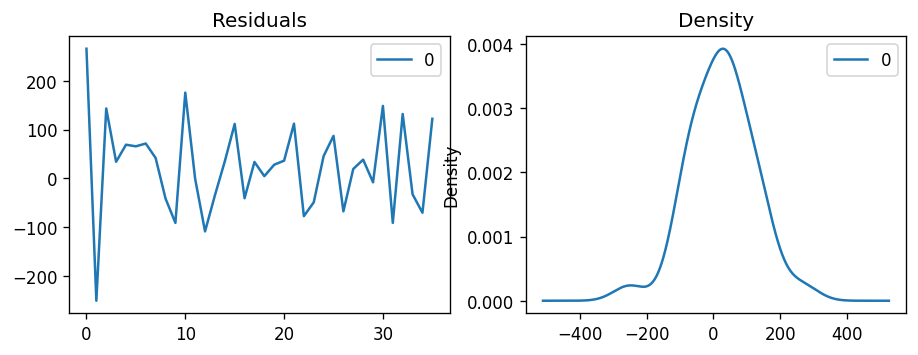

In [123]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

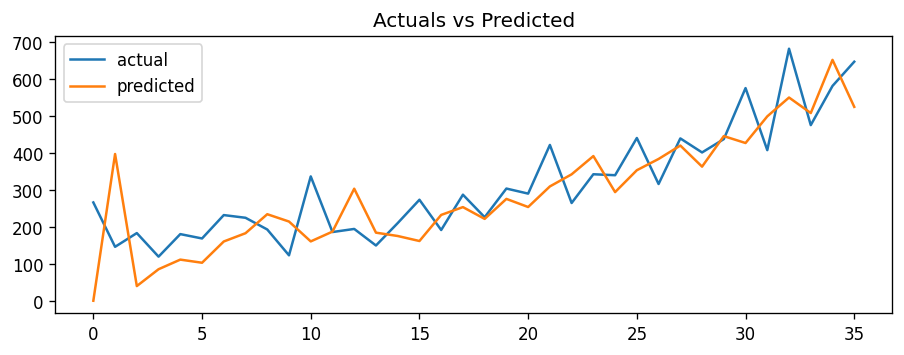

In [124]:
# Actual vs Fitted Plot
actual = df.sales
predicted = model_fit.predict()
pd.DataFrame({'actual':actual, 'predicted':predicted}).plot(title='Actuals vs Predicted');

In [125]:
# Create Training and Test
train = df.sales[:30]
test = df.sales[30:]
print(train.shape, test.shape)

(30,) (6,)


c:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


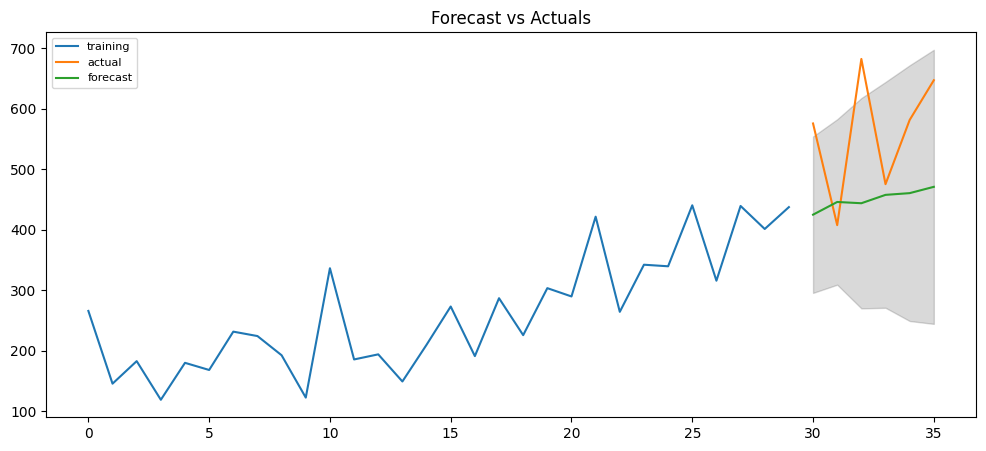

In [126]:
# Build Model
model = ARIMA(train, order=(1, 2, 1))
fitted = model.fit()

# Forecast
n_steps = test.shape[0]
fc = fitted.forecast(n_steps, alpha=0.05)  # 95% conf

# Get forecast with updated
forecast = fitted.get_forecast(steps=n_steps)

# Mean forecast
yhat = forecast.predicted_mean

# Confidence intervals of forecasts
conf = forecast.conf_int()

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf.iloc[:, 0], index=test.index)  # For alpha=0.05, use conf.iloc[:, 0]
upper_series = pd.Series(conf.iloc[:, 1], index=test.index)  # For alpha=0.05, use conf.iloc[:, 1]

# Plot
plt.figure(figsize=(12, 5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series,
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()


<b>Accuracy Metrics for Time Series Forecast</b>


Mean Absolute Percentage Error (MAPE)<br>
Mean Error (ME)<br>
Mean Absolute Error (MAE)<br>
Mean Percentage Error (MPE)<br>
Root Mean Squared Error (RMSE)<br>
Lag 1 Autocorrelation of Error (AC=F1)<br>
Correlation between the Actual and the Forecast (corr)<br>
Min-Max Error (minmax)<br>

In [128]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse,
            'corr':corr, 'minmax':minmax})

forecast_accuracy(fc, test.values)

C:\Users\Dell\AppData\Local\Temp\ipykernel_8900\3590771445.py:9: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  mins = np.amin(np.hstack([forecast[:,None],
C:\Users\Dell\AppData\Local\Temp\ipykernel_8900\3590771445.py:11: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  maxs = np.amax(np.hstack([forecast[:,None],


{'mape': 0.20366796925573202,
 'me': -110.83585318109097,
 'mae': 123.59900356116934,
 'mpe': -0.17235503898076054,
 'rmse': 145.35700991868504,
 'corr': 0.1048047232500344,
 'minmax': 0.20232351615109456}

<b>From the above evaluation metrics, we can gain several insights into the performance of your ARIMA model's predictions:</b><br>
<ol>
<li>
MAPE (Mean Absolute Percentage Error):
The MAPE measures the average percentage difference between the predicted values and the actual values. In this case, the MAPE is approximately 20.37%, which indicates that, on average, the model's predictions deviate from the actual values by about 20.37%. A lower MAPE value suggests better prediction accuracy.
</li>
<li>
ME (Mean Error):
The ME represents the average of the errors (residuals), which is the difference between predicted and actual values. In this case, the ME is approximately -110.84. A negative ME suggests that, on average, the model tends to underpredict the actual values.<br>
</li>
<li>
MAE (Mean Absolute Error):
The MAE is the average of the absolute differences between predicted and actual values. Here, the MAE is approximately 123.60. A lower MAE indicates better accuracy, as it measures the average magnitude of the prediction errors.<br>
</li>
<li>
MPE (Mean Percentage Error):
The MPE represents the average percentage error between predicted and actual values. In this case, the MPE is approximately -0.17%. A negative MPE suggests that, on average, the model's predictions are slightly lower than the actual values.<br>
</li>
<li>
RMSE (Root Mean Squared Error):
The RMSE is the square root of the average of the squared differences between predicted and actual values. In this case, the RMSE is approximately 145.36. Like MAE, a lower RMSE indicates better accuracy and measures the magnitude of prediction errors.<br>
</li>
<li>
Correlation (Corr):
The correlation measures the linear relationship between predicted and actual values. A correlation close to 1 indicates a strong positive linear relationship, while a correlation close to -1 indicates a strong negative linear relationship. In this case, the correlation is approximately 0.10, suggesting a weak positive linear relationship.
</li>
<li>
Min-Max (Minmax):
The Min-Max metric represents the maximum difference between predicted and actual values, scaled between 0 and 1. Here, the Min-Max value is approximately 0.20, indicating that the model's predictions can vary by up to 20% of the data range.
</li>
</ol>

AUTO ARIMA forecast 

In [129]:
import pmdarima as pm

model = pm.auto_arima(df.sales, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=402.407, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=430.873, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=405.977, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=408.967, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=429.229, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=404.226, Time=0.22 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=401.463, Time=0.44 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.47 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.61 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.13 sec

Best model:  ARIMA(1,1,2)(0,0,0)[0] intercept
Total fit time: 3.024 seconds
                               SARIMAX Results             